In [1]:
### 对应到完整版本Alg.1

In [2]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing,get_index_order
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate,MCXGate

from Pre import *

to_test = False

In [3]:
def state_pre(tdd,n=0,cond={},anc_num=1):

    if tdd.node.key==-1:
        return Circuit(0,[]),1
        
    if n==0:
        n = tdd.node.key+1
    cir = Circuit(n+1,[])
    qa = n
    
    the_map=tdd.map

    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            # cir.x(q)
            cir.data.append(Gate('x',{},q))
        if the_map.rotate>0:
            # cir.p(np.pi/4*(8-the_map.rotate),q)
            cir.data.append(Gate('p',{},q,np.pi/4*(8-the_map.rotate)))
        the_map=the_map.father
    
    u = tdd.node
    the_map = u.out_maps[1]
    
    while the_map.level>-1:
        q1 = u.key
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            # cir.ccx(qa,q1,q)
            cir.data.append(Gate('x',{qa:1,q1:1},q))
        if the_map.rotate>0:
            # cir.mcp(np.pi/4*(8-the_map.rotate),[qa, q1],q)
            cir.data.append(Gate('p',{qa:1,q1:1},q,np.pi/4*(8-the_map.rotate)))
        the_map=the_map.father
    
    if u.successor[0]!=u.successor[1]:
        #把1分支关闭
        cond_qubit = [u.key] + [k for k in cond]
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
        # print('a',cond_qubit,qa)
        # cir.mcx(cond_qubit,qa)
        cir.data.append(Gate('x',{k:1 for k in cond_qubit},qa))
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
    
    # cond[u.key]=0
        bran_tdd = get_branch_dd(u,0)
        cir_end_t0, hold_prob0 = state_pre(bran_tdd,n,cond|{u.key:0},anc_num)
        cir.data=cir.data+cir_end_t0.data
    
    # if u.successor[0]!=u.successor[1]:
        #把0分支关闭，1分支打开
        cond_qubit = [k for k in cond]
        if len(cond_qubit)==0:
            # cir.x(qa)
            cir.data.append(Gate('x',{},qa))
        else:
            for k in cond:
                if cond[k]==0:
                    # cir.x(k)
                    cir.data.append(Gate('x',{},k))
            # print('b',cond_qubit,qa)
            # cir.mcx(cond_qubit,qa)
            cir.data.append(Gate('x',{k:1 for k in cond_qubit},qa))
            for k in cond:
                if cond[k]==0:
                    # cir.x(k)
                    cir.data.append(Gate('x',{},k))
        
        bran_tdd = get_branch_dd(u,1)
        cir_end_t1, hold_prob1 = state_pre(bran_tdd,n,cond|{u.key:1},anc_num)
        cir.data=cir.data+cir_end_t1.data
        
        #把0分支再打开
        cond_qubit = [u.key] + [k for k in cond]
        # cir.x(u.key)
        cir.data.append(Gate('x',{},u.key))
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
        # print('c',cond_qubit,qa)
        # cir.mcx(cond_qubit,qa)
        cir.data.append(Gate('x',{k:1 for k in cond_qubit},qa))
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
        # cir.x(u.key)
        cir.data.append(Gate('x',{},u.key))
    else:
        bran_tdd = get_branch_dd(u,0)
        cir_end_t0, hold_prob0 = state_pre(bran_tdd,n,cond,anc_num)
        cir.data=cir.data+cir_end_t0.data
        hold_prob1 = hold_prob0        
        
    w0 = u.out_weight[0]*hold_prob0
    w1 = u.out_weight[1]*hold_prob1
    a=w1/w0
    if abs(a)>1e-10:
        M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
        # u3 = UnitaryGate(M)
        # cu3 = u3.control(1)
        # cir.append(cu3,[qa,u.key])
        cir.data.append(Gate('u',{qa:1},u.key,M))
    hold_prob = w0*np.sqrt(1+abs(a)**2)
    return cir, hold_prob

def extend_tdd(tdd):
    var=[]
    q_n = tdd.node.key+2
    for k1 in range(q_n):
        if not 'x'+str(k1) in var:
            var.append('x'+str(k1))
        if not 'a'+str(k1) in var:
            var.append('a'+str(k1))        
        for k in range(30*q_n):
            s ='x'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)
            s ='y'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)               
        if not 'y'+str(k1) in var:
            var.append('y'+str(k1))
        if not 'b'+str(k1) in var:
            var.append('b'+str(k1))        
    var.reverse()
    set_index_order(var)

    U0=np.array([1,0])
    U1=np.array([0,1])
    tdd_new = tdd.self_copy()
    for q in range(tdd.node.key+1,q_n,1):
        if q==tdd.node.key+1:
            ts=Tensor(U1,[Index('y'+str(q))],'out',[k])
        else:
            ts=Tensor(U0,[Index('y'+str(q))],'out',[k])
        tdd_new=cont(tdd_new,ts.tdd())
    return tdd_new

def is_zero_state(node):
    if node.key==0:
        return True
    if node.successor[0]!=node.successor[1]:
        return False
    if node.out_weight[0]!=1 or node.out_weight[1]!=0:
        return False
    if node.out_maps[1].level!=-1:
        return False
    return is_zero_state(node.successor[0])
    
def is_successful(tdd,n):
    if tdd.map.level!=n:
        return False
    if tdd.map.x!=1:
        return False
    if tdd.map.rotate!=0:
        return False
    if tdd.map.father.level!=-1:
        return False
    return is_zero_state(tdd.node)

{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2'}
0.07967519760131836


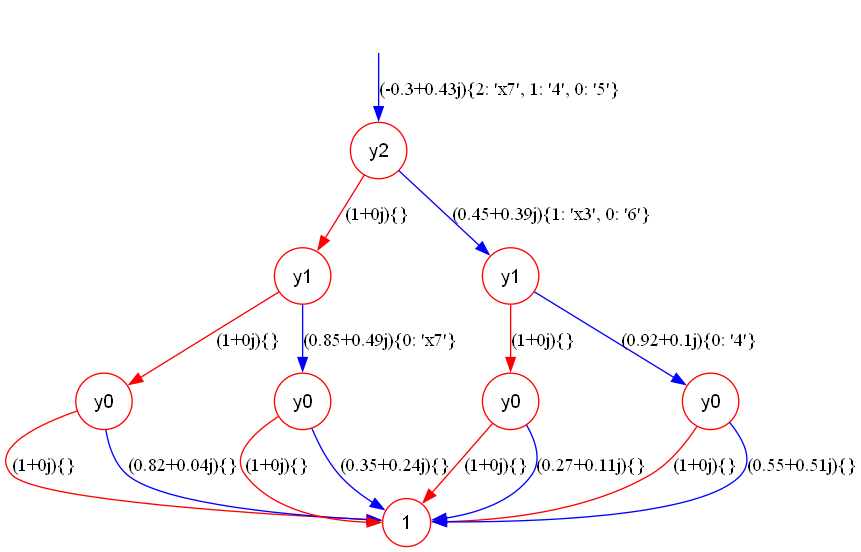

In [4]:
n=3
m=100

cir=gen_cir('Random_Clifford_T',n,m)
t_start = time.time()
tdd=simulate(cir,True,n)
print(tdd.key_2_index)
print(time.time()-t_start)
# tdd=renormalize(tdd)
tdd.show()

0.002001047134399414
1
3
4
True


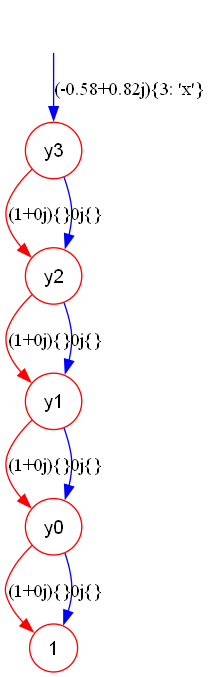

In [5]:
cir_head = QuantumCircuit(n+1)
t_start = time.time()
cir_end,_ = state_pre(tdd.self_copy())
print(time.time()-t_start)
print('1')
tdd_new = extend_tdd(tdd)
# print('2')
cir_end = cir_end.to_qis_cir()
tdd_new2 = update_tdd(tdd_new,cir_head,cir_end)
print('3')
tdd_new2 = renormalize(tdd_new2)
print('4')
print(is_successful(tdd_new2,n))
tdd_new2.show()